## Create the machine learning algorithm



### Import the relevant libraries

In [2]:
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt

### Load Data

In [3]:
records = []

npz = np.load('Audiobooks_data_train.npz')

train_inputs = npz['inputs'].astype(float)
train_targets = npz['targets'].astype(int)

npz = np.load('Audiobooks_data_validation.npz')
validation_inputs, validation_targets = npz['inputs'].astype(float), npz['targets'].astype(int)

npz = np.load('Audiobooks_data_test.npz')
test_inputs, test_targets = npz['inputs'].astype(float), npz['targets'].astype(int)

In [285]:
train_inputs.shape

(3579, 10)

In [286]:
test_targets.shape

(448,)

In [287]:
train_targets

array([0, 1, 1, ..., 1, 1, 0])

## Model

In [ ]:
config = {
    'input_size': 10,
    'hidden_layer_size': 64,
    'output_size': 1,
    'learning_rate': 0.00008,
    'batch_size': 64,
    'epoch_size': 200
}

model = tf.keras.Sequential([
    # tf.keras.Input(shape=(config['input_size'],)),

    tf.keras.layers.Dense(config['hidden_layer_size'], activation='relu'),    # 1st hidden layer
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Dense(config['hidden_layer_size'], activation='relu'),    # 2nd hidden layer
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Dense(config['hidden_layer_size'], activation='relu'),    # 3rd hidden layer
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Dense(config['output_size'], activation='sigmoid')
])

custom_optimizer = tf.keras.optimizers.Adam(learning_rate=config['learning_rate'])
model.compile(optimizer=custom_optimizer, loss='binary_crossentropy', metrics=['accuracy'])

## Training

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, min_lr=1e-6)
early_stopping = EarlyStopping(patience=3)   #patience: 可以容忍至多3個上下震盪的val loss，防止overfitting

# val_loss 開始上下震盪 -> Overfitting，使用EarlyStopping()
history = model.fit(
    train_inputs,
    train_targets,
    batch_size=config['batch_size'],
    epochs=config['epoch_size'],
    callbacks=[early_stopping, lr_scheduler],
    validation_data=(validation_inputs, validation_targets),
    verbose=2
)


Epoch 1/200
56/56 - 2s - 31ms/step - accuracy: 0.6331 - loss: 0.6185 - val_accuracy: 0.6667 - val_loss: 0.6608 - learning_rate: 8.0000e-05
Epoch 2/200
56/56 - 0s - 1ms/step - accuracy: 0.7075 - loss: 0.5214 - val_accuracy: 0.7159 - val_loss: 0.6187 - learning_rate: 8.0000e-05
Epoch 3/200
56/56 - 0s - 906us/step - accuracy: 0.7295 - loss: 0.4869 - val_accuracy: 0.7427 - val_loss: 0.5642 - learning_rate: 8.0000e-05
Epoch 4/200
56/56 - 0s - 891us/step - accuracy: 0.7530 - loss: 0.4532 - val_accuracy: 0.7763 - val_loss: 0.5080 - learning_rate: 8.0000e-05
Epoch 5/200
56/56 - 0s - 878us/step - accuracy: 0.7597 - loss: 0.4415 - val_accuracy: 0.7919 - val_loss: 0.4591 - learning_rate: 8.0000e-05
Epoch 6/200
56/56 - 0s - 921us/step - accuracy: 0.7664 - loss: 0.4273 - val_accuracy: 0.8009 - val_loss: 0.4235 - learning_rate: 8.0000e-05
Epoch 7/200
56/56 - 0s - 877us/step - accuracy: 0.7737 - loss: 0.4166 - val_accuracy: 0.8009 - val_loss: 0.3994 - learning_rate: 8.0000e-05
Epoch 8/200
56/56 - 0s 

In [30]:
from sklearn.model_selection import KFold
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

import numpy as np
import tensorflow as tf

config = {
    'input_size': 10,
    'hidden_layer_size': 64,
    'output_size': 1,
    'learning_rate': 0.00003,
    'batch_size': 100,
    'epoch_size': 100
}

k_fold_validation_inputs = train_inputs 
k_fold_validation_targets = train_targets  

k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)

fold_accuracies = []

for train_index, val_index in kf.split(k_fold_validation_inputs):
    x_train, x_val = k_fold_validation_inputs[train_index], k_fold_validation_inputs[val_index]
    y_train, y_val = k_fold_validation_targets[train_index], k_fold_validation_targets[val_index]
    
    # model = tf.keras.Sequential([
    #     tf.keras.layers.Dense(config['hidden_layer_size'], activation='relu', 
    #                           kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    #     tf.keras.layers.BatchNormalization(),

    #     tf.keras.layers.Dense(config['hidden_layer_size'], activation='relu',
    #                           kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    #     tf.keras.layers.BatchNormalization(),
        
    #     # tf.keras.layers.Dense(config['hidden_layer_size'], activation='relu',
    #     #                       kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    #     # tf.keras.layers.BatchNormalization(),
    #     tf.keras.layers.Dense(config['output_size'], activation='sigmoid')
    # ])

    model = tf.keras.Sequential([
        tf.keras.layers.Dense(config['hidden_layer_size'], activation='relu'),
        tf.keras.layers.Dense(config['hidden_layer_size'], activation='relu'),
        tf.keras.layers.Dense(config['hidden_layer_size'], activation='relu'),
        tf.keras.layers.Dense(config['output_size'], activation='sigmoid')
    ])
    
    custom_optimizer = tf.keras.optimizers.Adam(learning_rate=config['learning_rate'])
    model.compile(optimizer=custom_optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    
    lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6)
    early_stopping = EarlyStopping(patience=5, restore_best_weights=True)
    
    history = model.fit(
        x_train, y_train,
        batch_size=config['batch_size'],
        epochs=config['epoch_size'],
        validation_data=(x_val, y_val),
        callbacks=[early_stopping, lr_scheduler],
        verbose=2
    )
    
    val_loss, val_accuracy = model.evaluate(x_val, y_val, verbose=0)
    fold_accuracies.append(val_accuracy)

fold_accuracies = np.array(fold_accuracies)
print(f"10-Fold Cross-Validation Accuracy: {fold_accuracies.mean():.4f} ± {fold_accuracies.std():.4f}")


Epoch 1/100
29/29 - 1s - 21ms/step - accuracy: 0.5320 - loss: 0.6840 - val_accuracy: 0.5573 - val_loss: 0.6794 - learning_rate: 3.0000e-05
Epoch 2/100
29/29 - 0s - 1ms/step - accuracy: 0.5592 - loss: 0.6781 - val_accuracy: 0.5950 - val_loss: 0.6735 - learning_rate: 3.0000e-05
Epoch 3/100
29/29 - 0s - 1ms/step - accuracy: 0.5816 - loss: 0.6724 - val_accuracy: 0.6187 - val_loss: 0.6678 - learning_rate: 3.0000e-05
Epoch 4/100
29/29 - 0s - 1ms/step - accuracy: 0.5976 - loss: 0.6668 - val_accuracy: 0.6341 - val_loss: 0.6624 - learning_rate: 3.0000e-05
Epoch 5/100
29/29 - 0s - 1ms/step - accuracy: 0.6238 - loss: 0.6613 - val_accuracy: 0.6550 - val_loss: 0.6569 - learning_rate: 3.0000e-05
Epoch 6/100
29/29 - 0s - 1ms/step - accuracy: 0.6385 - loss: 0.6559 - val_accuracy: 0.6662 - val_loss: 0.6514 - learning_rate: 3.0000e-05
Epoch 7/100
29/29 - 0s - 1ms/step - accuracy: 0.6608 - loss: 0.6505 - val_accuracy: 0.6844 - val_loss: 0.6460 - learning_rate: 3.0000e-05
Epoch 8/100
29/29 - 0s - 1ms/step

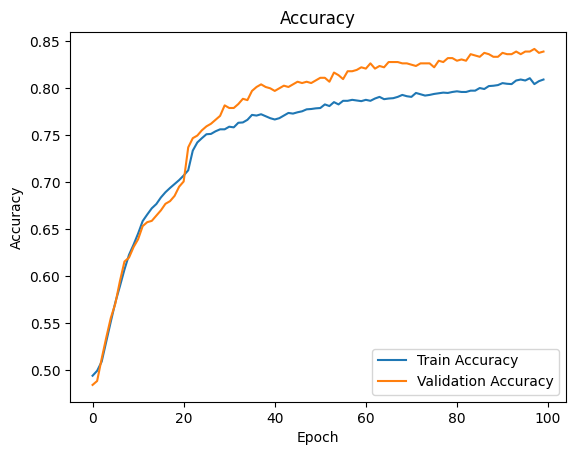

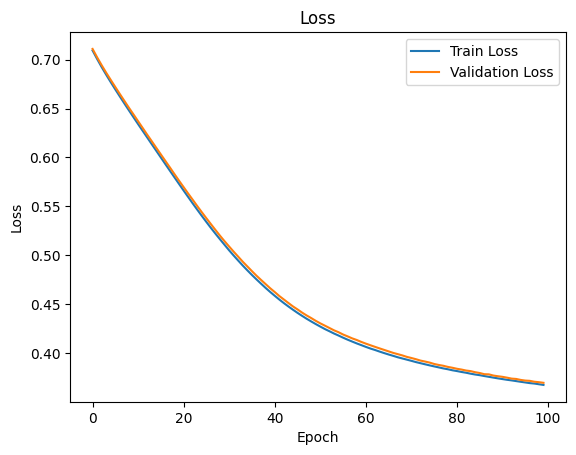

In [31]:
# Plot accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

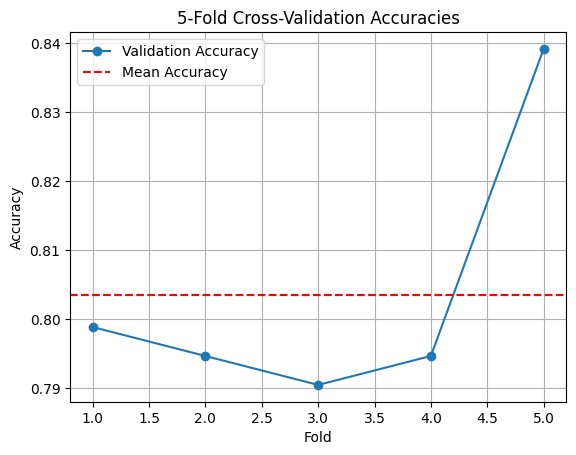

In [32]:
folds = range(1, k + 1)  

plt.plot(folds, fold_accuracies, marker='o', label='Validation Accuracy')
plt.axhline(y=fold_accuracies.mean(), color='r', linestyle='--', label='Mean Accuracy')

plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.title('5-Fold Cross-Validation Accuracies')
plt.legend()
plt.grid()
plt.show()


## Test

In [33]:
test_loss, test_accuracy = model.evaluate(test_inputs, test_targets)
print('Test loss: {0:.2f}. Test accuracy: {1:.2f}%'.format(test_loss, test_accuracy*100.))

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 575us/step - accuracy: 0.8016 - loss: 0.3767
Test loss: 0.38. Test accuracy: 79.91%


## Record hidden layer size, batch, epoch, accuracy


In [34]:
records.append({
    'hidden_layer_size': hidden_layer_size,
    'batch': batch,
    'epoch': epoch_size,
    'test_loss': round(test_loss, 2), 
    'test_accuracy': round(test_accuracy, 3)
})

# Convert to a DataFrame
df = pd.DataFrame(records)

df.to_json('records.json', orient='records', indent=4)


NameError: name 'hidden_layer_size' is not defined

In [ ]:
df = pd.read_json('records.json')

max_accuracy = df['test_accuracy'].max()

highest_accuracy_indices = df[df['test_accuracy'] == max_accuracy]

print(highest_accuracy_indices)


    hidden_layer_size  batch  epoch  test_loss  test_accuracy
14                 50     64    100        0.8          0.806
